In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

pd.set_option("display.max_columns", None)
seed = 42


candidates = [
    Path("./data/LSE_DA301_assignment_files_new/turtle_reviews.csv"),
    Path("./data/turtle_reviews.csv"),
    Path("../data/LSE_DA301_assignment_files_new/turtle_reviews.csv"),
    Path("../data/turtle_reviews.csv"),
]

csv_path = None
for p in candidates:
    if p.exists():
        csv_path = p
        break

if csv_path is None:

    for p in Path(".").rglob("turtle_reviews.csv"):
        csv_path = p
        break

assert csv_path is not None, "Couldn't find turtle_reviews.csv. Tell me where it is and I'll fix the path."

print(f"Using file: {csv_path}")
df = pd.read_csv(csv_path)

display(df.head(10))
print("\n--- INFO ---")
df.info()
print("\n--- DESCRIBE (numeric) ---")
display(df.describe())

print("\n--- Columns ---")
print(list(df.columns))


lower_cols = {c.lower(): c for c in df.columns}
candidates_loyal = [orig for lower, orig in lower_cols.items() if "loyal" in lower and ("point" in lower or "pts" in lower)]

if candidates_loyal:
    print("\nPossible loyalty points column(s):", candidates_loyal)
else:
    print("\nNo obvious 'loyalty points' column found. Here are numeric columns to choose from:")
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    print(num_cols)

Using file: turtle_reviews.csv


,gender,age,remuneration (k£),spending_score (1-100),loyalty_points,education,language,platform,product,review,summary
0,Male,18,12.30,39,210,graduate,EN,Web,453,"When it comes to a DM's screen, the space on t...",The fact that 50% of this space is wasted on a...
1,Male,23,12.30,81,524,graduate,EN,Web,466,An Open Letter to GaleForce9*:\n\nYour unpaint...,Another worthless Dungeon Master's screen from...
2,Female,22,13.12,6,40,graduate,EN,Web,254,"Nice art, nice printing. Why two panels are f...","pretty, but also pretty useless"
3,Female,25,13.12,77,562,graduate,EN,Web,263,Amazing buy! Bought it as a gift for our new d...,Five Stars
4,Female,33,13.94,40,366,graduate,EN,Web,291,As my review of GF9's previous screens these w...,Money trap
5,Female,24,13.94,76,573,PhD,EN,Web,977,Grandson loves,Five Stars
6,Female,37,14.76,6,61,diploma,EN,Web,979,"I have bought many gm screens over the years, ...",Best gm screen ever
7,Female,25,14.76,94,772,graduate,EN,Web,1012,Came in perfect condition.,Five Stars
8,Male,66,15.58,3,31,PhD,EN,Web,1031,Could be better but its still great. I love th...,Great but could be even better
9,Female,32,15.58,72,724,PhD,EN,Web,1459,My review will mirror others in that this kind...,Another missed opportunity. Not a value add t...



--- INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender                  2000 non-null   object 
 1   age                     2000 non-null   int64  
 2   remuneration (k£)       2000 non-null   float64
 3   spending_score (1-100)  2000 non-null   int64  
 4   loyalty_points          2000 non-null   int64  
 5   education               2000 non-null   object 
 6   language                2000 non-null   object 
 7   platform                2000 non-null   object 
 8   product                 2000 non-null   int64  
 9   review                  2000 non-null   object 
 10  summary                 2000 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 172.0+ KB

--- DESCRIBE (numeric) ---


,age,remuneration (k£),spending_score (1-100),loyalty_points,product
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,39.495000,48.079060,50.000000,1578.032000,4320.521500
std,13.573212,23.123984,26.094702,1283.239705,3148.938839
min,17.000000,12.300000,1.000000,25.000000,107.000000
25%,29.000000,30.340000,32.000000,772.000000,1589.250000
50%,38.000000,47.150000,50.000000,1276.000000,3624.000000
75%,49.000000,63.960000,73.000000,1751.250000,6654.000000
max,72.000000,112.340000,99.000000,6847.000000,11086.000000



--- Columns ---
['gender', 'age', 'remuneration (k£)', 'spending_score (1-100)', 'loyalty_points', 'education', 'language', 'platform', 'product', 'review', 'summary']

Possible loyalty points column(s): ['loyalty_points']


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


numeric_cols = ['age', 'remuneration (k£)', 'spending_score (1-100)']
categorical_cols = ['gender', 'education', 'language', 'platform']
target = 'loyalty_points'

X = df[numeric_cols + categorical_cols]
y = df[target]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)


print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R²:", r2_score(y_test, y_pred))

RMSE: 522.1857787224773
R²: 0.8318538596804532


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


                   Feature   Coefficient
4              gender_Male -9.724558e+15
3            gender_Female -9.724558e+15
9   education_postgraduate -3.435940e+15
6            education_PhD -3.435940e+15
8       education_graduate -3.435940e+15
7        education_diploma -3.435940e+15
5          education_Basic -3.435940e+15
2   spending_score (1-100)  8.821156e+02
1        remuneration (k£)  7.967137e+02
0                      age  1.494697e+02
10             language_EN  0.000000e+00
11            platform_Web  0.000000e+00


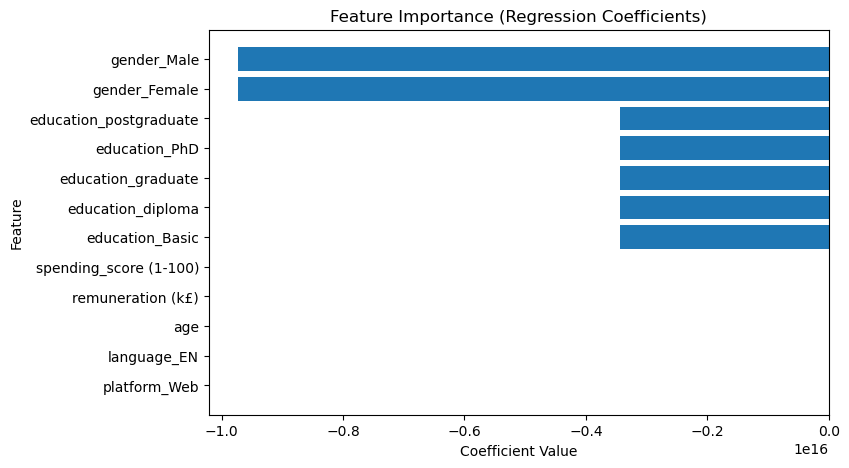

In [8]:

import numpy as np

# Get feature names after preprocessing
ohe = reg.named_steps['preprocessor'].named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)
feature_names = numeric_cols + list(ohe_feature_names)

# Coefficients from the linear model
coefs = reg.named_steps['model'].coef_


coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(coef_df)


import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.barh(coef_df['Feature'], coef_df['Coefficient'])
plt.title("Feature Importance (Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Tree RMSE: 318.6444751359348
Tree R²: 0.9373891487552022


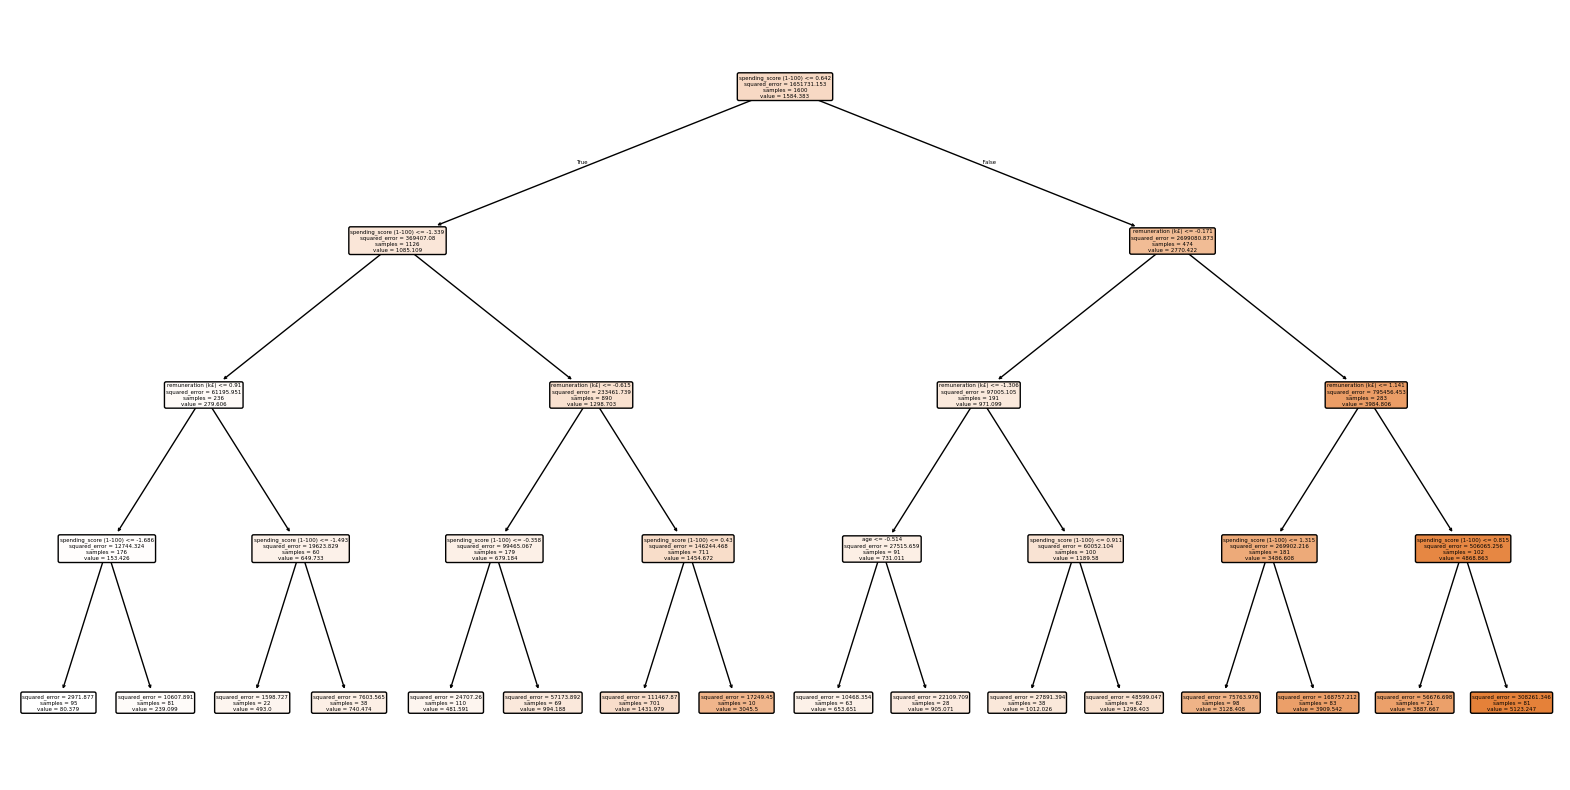

In [10]:
from sklearn.tree import DecisionTreeRegressor, plot_tree


tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(max_depth=4, random_state=42))
])

tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)


print("Tree RMSE:", mean_squared_error(y_test, y_pred_tree, squared=False))
print("Tree R²:", r2_score(y_test, y_pred_tree))


# To plot with feature names, we need to get them after preprocessing
ohe = tree.named_steps['preprocessor'].named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)
feature_names = numeric_cols + list(ohe_feature_names)


tree_model = tree.named_steps['model']

plt.figure(figsize=(20,10))
plot_tree(tree_model, feature_names=feature_names, filled=True, rounded=True)
plt.show()

Silhouette Score (k=3): 0.457


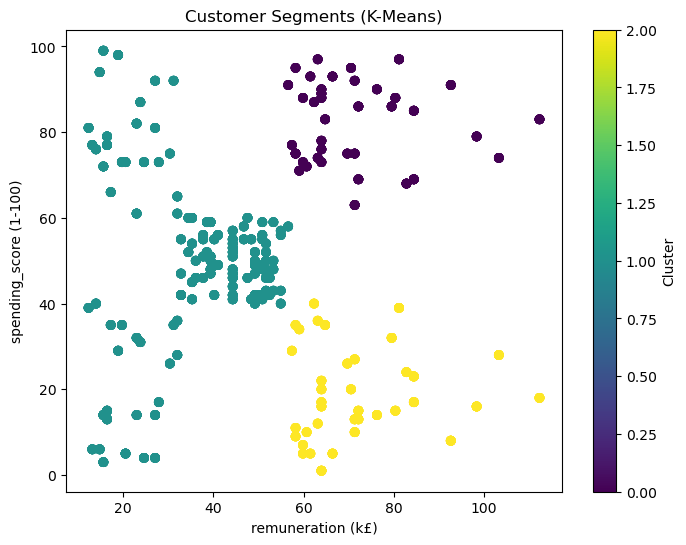

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


cluster_cols = ['remuneration (k£)', 'spending_score (1-100)']
X_cluster = df[cluster_cols].dropna()
 
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
labels = kmeans.fit_predict(X_cluster)


df['cluster'] = None
df.loc[X_cluster.index, 'cluster'] = labels


sil_score = silhouette_score(X_cluster, labels)
print(f"Silhouette Score (k=3): {sil_score:.3f}")


plt.figure(figsize=(8,6))
plt.scatter(X_cluster[cluster_cols[0]], X_cluster[cluster_cols[1]], c=labels, cmap='viridis')
plt.xlabel(cluster_cols[0])
plt.ylabel(cluster_cols[1])
plt.title('Customer Segments (K-Means)')
plt.colorbar(label='Cluster')
plt.show()

In [14]:
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer


text_col = 'review'   # change to 'summary' if you prefer
assert text_col in df.columns, f"Column '{text_col}' not found. Available: {list(df.columns)}"


texts = df[text_col].fillna("").astype(str)

def simple_clean(s):
    s = s.lower()
    s = re.sub(r"[^a-z0-9\s']", " ", s)  # drop punctuation/symbols
    s = re.sub(r"\s+", " ", s).strip()
    return s

texts_clean = texts.apply(simple_clean)


vec = CountVectorizer(stop_words='english', max_features=5000)  # cap features to keep it light
X_text = vec.fit_transform(texts_clean)
vocab = vec.get_feature_names_out()

word_counts = X_text.sum(axis=0).A1
top_idx = word_counts.argsort()[::-1][:15]
top_words = pd.DataFrame({
    "word": vocab[top_idx],
    "count": word_counts[top_idx]
})
print("Top 15 words:")
display(top_words)


pos_words = [
    "good","great","excellent","amazing","love","loved","like","liked","fantastic",
    "perfect","awesome","happy","enjoy","enjoyed","best","recommend","fun","nice"
]
neg_words = [
    "bad","poor","terrible","awful","hate","hated","disappoint","disappointed",
    "worst","broken","bug","bugs","lag","laggy","boring","slow","refund","return"
]

pos_pattern = r"\b(" + "|".join(pos_words) + r")\b"
neg_pattern = r"\b(" + "|".join(neg_words) + r")\b"

df["pos_hits"] = texts_clean.str.count(pos_pattern)
df["neg_hits"] = texts_clean.str.count(neg_pattern)
df["sent_proxy"] = df["pos_hits"] - df["neg_hits"]


top20_pos = df.sort_values(["pos_hits","neg_hits"], ascending=[False, True]).head(20)[[text_col,"pos_hits","neg_hits","sent_proxy"]]
top20_neg = df.sort_values(["neg_hits","pos_hits"], ascending=[False, True]).head(20)[[text_col,"pos_hits","neg_hits","sent_proxy"]]

print("\nTop 20 positive reviews (by keyword hits):")
display(top20_pos)

print("\nTop 20 negative reviews (by keyword hits):")
display(top20_neg)


outdir = Path("./outputs"); outdir.mkdir(exist_ok=True)
top_words.to_csv(outdir / "nlp_top15_words.csv", index=False)
top20_pos.to_csv(outdir / "nlp_top20_positive_reviews.csv", index=False)
top20_neg.to_csv(outdir / "nlp_top20_negative_reviews.csv", index=False)

Top 15 words:


,word,count
0,game,1713
1,great,598
2,fun,558
3,play,509
4,like,421
5,just,375
6,love,332
7,really,319
8,cards,306
9,tiles,300



Top 20 positive reviews (by keyword hits):


,review,pos_hits,neg_hits,sent_proxy
358,This kit is AWESOME! My 5-year old daughter an...,20,0,20
1097,I have a wife and kids & I don't have time to ...,18,2,16
1295,"Lords of Waterdeep was awesome, and Scoundrels...",18,3,15
1584,"nice good good great quick ship awesome good, ...",17,0,17
1121,Disclaimer: Bought this from a local store. Pa...,15,2,13
1570,As a dad of two boys Im always on the lookout ...,13,0,13
1103,Who am I:\nMiddle aged married guy who loves S...,11,0,11
879,"Whenever I see this game on my shelf, I get a ...",11,3,8
156,I'm 37 years old and I just took up drawing ag...,10,0,10
1666,If you only employ one creativity-enhancing re...,10,0,10



Top 20 negative reviews (by keyword hits):


,review,pos_hits,neg_hits,sent_proxy
1015,I wish I'd watched some of the gameplay videos...,9,4,5
13,This is one of the worst games I have ever pla...,0,3,-3
16,Pretty good book with a variety of unique card...,1,3,-2
1069,For those just getting started in the DnD worl...,3,3,0
879,"Whenever I see this game on my shelf, I get a ...",11,3,8
1295,"Lords of Waterdeep was awesome, and Scoundrels...",18,3,15
174,I sent this product to my granddaughter. The p...,0,2,-2
551,"My son loves the books, but was very disappoin...",0,2,-2
1613,I was so disappointed to receive my Little Old...,0,2,-2
328,item arrived defective so that we had to send ...,1,2,-1


In [16]:
from pathlib import Path
Path("outputs").mkdir(exist_ok=True)


plt.savefig("outputs/py_clusters.png", dpi=200, bbox_inches="tight")


coef_df.to_csv("outputs/py_regression_feature_importance.csv", index=False)


top_words.to_csv("outputs/nlp_top15_words.csv", index=False)
top20_pos.to_csv("outputs/nlp_top20_positive_reviews.csv", index=False)
top20_neg.to_csv("outputs/nlp_top20_negative_reviews.csv", index=False)

<Figure size 640x480 with 0 Axes>